# **Neural Affine Flow**

Author: Suyong Choi (Korea University, Department of Physics)

We implement neural affine flow (arXiv:1804.00779) and show how it can be used for morphing distributions.

# Introduction
ABCDnn is a method using a DNN for ABCD-type extrapolation. This method allows that multi-dimensional distributions can be predicted, and the information from control regions (CRs) for predicting signal region (SR) distributions can be optimally used through a DNN. For all-hadronic 4-top analysis, jet multiplicity ($N_{j}$) and the b-jet multiplicity ($N_{b}$) are used as the control variables to subdivide the phase space in two dimensions. In addition, we use a total of 5 CRs by adding two additional CR bins in jet multiplicity to 3 CRs of the regular ABCD method to use more information.  

In this codes, the ABCDnn is used to predict the SR distribution of background events in data by morphing the distribution of simulated events in the SR (see [the method schematics of ABCDnn](https://gitlab.cern.ch/haoh/abcdnn/-/blob/master/ABCDnn_schematic2.png)). ABCDnn learns an invertible bijective functions that transforms the distributions of the feature variables in the 5 CRs of the simulation into the distribution of the feature variable of the data under the same condition. The transformations between the distributions of feature variables under different conditions are constructed as an invertible bijective function through neural autoregressive flow (NAF, arXiv:1804.00779v1). The training proceeds in the direction of minimizing the maximum-mean-discrepancy (MMD) between the distributions of source and target. After the training, the transformation between source and target under the SR condition is applied to the distribution of the simulated events in the SR, which is morphed to predict the shape of the background in the SR. Note that the distribution of data in the SR is not used when ABCDnn training. Also, ABCDnn cannot be used for yield prediction since the number of events of the source is preserved due to invertible transformation.

# Preparation

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [2]:
# imports
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_probability as tfp
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
tfb = tfp.bijectors
tfk = keras
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
!pip install uproot==3.12.0
!pip install scikit-hep==1.2.1
from skhep.visual import MplPlotter

# Construct NAF

In [4]:
!cp "/drive/My Drive/construct_NAF.py" .
from construct_NAF import invsigmoid, NAF

# Learning Rate Scheduling


In [5]:
!cp "/drive/My Drive/learning_rate_scheduling.py" .
from learning_rate_scheduling import SawtoothSchedule

# MMD Loss

In [6]:
!cp "/drive/My Drive/mmd_loss.py" .
from mmd_loss import mix_rbf_kernel, mix_rbf_mmd2

# ABCDnn

In [7]:
class ABCDdnn(object):
    def __init__(self, inputdim_categorical_list, inputdim, ndense=128, minibatch=128, nafdim=16, depth=2, lr = 0.0005, gap = 100000, \
        conddim=0, beta1=0.5, beta2=0.9, lamb=1.0, retrain=False, savedir='./abcdnn/', savefile='abcdnn.pkl', seed=100, permute=True):
        self.inputdim_categorical_list = inputdim_categorical_list
        self.inputdim = inputdim
        self.ndense = ndense
        self.inputdimcat = int(np.sum(inputdim_categorical_list))
        self.inputdimreal = inputdim - self.inputdimcat
        self.minibatch = minibatch
        self.nafdim = nafdim
        self.depth = depth
        self.lr = lr
        self.gap = gap
        self.conddim = conddim
        self.beta1 = beta1
        self.beta2 = beta2
        self.lamb = lamb
        self.retrain = retrain
        self.savedir = savedir
        self.savefile = savefile
        self.global_step = tf.Variable(0, name='global_step')
        self.monitor_record = []
        self.monitorevery = 100
        self.seed = seed
        self.permute = permute
        self.setup()

    def setup(self):
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        self.createmodel()
        self.checkpoint = tf.train.Checkpoint(global_step=self.global_step, model = self.model, optimizer=self.optimizer)
        self.checkpointmgr = tf.train.CheckpointManager(self.checkpoint, directory=self.savedir, max_to_keep=10)
        if (not self.retrain) and os.path.exists(self.savedir):
            status = self.checkpoint.restore(self.checkpointmgr.latest_checkpoint)
            status.assert_existing_objects_matched()
            print('loaded model from checkpoint')
            if os.path.exists(os.path.join(self.savedir, self.savefile)):
                print("Reading monitor file")
                self.load_training_monitor()
            print("Resuming from step", self.global_step)
        elif not os.path.exists(self.savedir):
            os.mkdir(self.savedir)
        pass

    def createmodel(self):
        #inputlayer = layers.Input(shape=(self.inputdimreal+self.inputdimcat+self.conddim+self.conddim,))
        inputlayer = layers.Input(shape=(self.inputdimreal+self.inputdimcat+self.conddim,))
        net = inputlayer
        noutdim = self.inputdimreal + self.inputdimcat
        self.model = NAF(self.inputdim,self.ndense,self.conddim, nafdim=self.nafdim, depth=self.depth, permute=self.permute)
        self.model.summary()
        #tf.keras.utils.plot_model(self.model, to_file=self.savedir+'ABCD_dnn.png')
        lr_fn = SawtoothSchedule(self.lr*10, self.lr, self.gap,0)
        self.optimizer = tfk.optimizers.Adam(learning_rate = lr_fn,  beta_1=self.beta1, beta_2=self.beta2, epsilon=1e-5, name='nafopt')
        pass

    def category_sorted(self, numpydata):
        categoricals, categorical_cats, unique_counts = np.unique(numpydata[:, self.inputdimreal:], axis=0, return_inverse=True, return_counts=True)
        print(f'Data has {categoricals} unique  categorical features. The counts in categories are')
        print(unique_counts)

        # store indices separately for easy access later
        categorical_indices_grouped=[]
        for icat in range(len(categoricals)):
            cat_indices = np.where(categorical_cats == icat)[0]
            categorical_indices_grouped.append(cat_indices)
        
        return categoricals, categorical_indices_grouped

    def setrealdata(self, numpydata):
        self.numpydata = numpydata
        self.ntotalevents = numpydata.shape[0]
        self.datacounter = 0
        self.randorder = np.random.permutation(self.numpydata.shape[0])
        # following is dummy
        self.dataeventweight = np.ones((self.ntotalevents, 1), np.float32)
        # find unique occurrenes of categorical features in data
        self.categoricals_data, self.categorical_data_indices_grouped = self.category_sorted(self.numpydata)
        pass

    def setmcdata(self, numpydata, eventweight=None):
        self.mcnumpydata = numpydata
        self.mcntotalevents = numpydata.shape[0]
        self.mcdatacounter = 0
        self.mcrandorder = np.random.permutation(self.mcnumpydata.shape[0])
        if eventweight is not None:
            self.mceventweight = eventweight
        else:
            self.mceventweight = np.ones((self.mcntotalevents, 1), np.float32)
        self.categoricals_mc, self.categorical_mc_indices_grouped = self.category_sorted(self.mcnumpydata)
        pass


    def savehyperparameters(self):
        """Write hyper parameters into file
        """
        params = [self.inputdim, self.conddim, self.lr, self.gap, self.ndense, self.nafdim, self.beta1, self.beta2, self.minibatch, self.nafdim, self.depth]
        pickle.dump(params, open(os.path.join(self.savedir, 'hyperparams.pkl'), 'wb'))

    def monitor(self):
        self.monitor_record.append([self.checkpoint.global_step.numpy(), self.glossv.numpy(), self.mmdloss])

    def save_training_monitor(self):
        pickle.dump(self.monitor_record, open(os.path.join(self.savedir, self.savefile), 'wb'))
        pass

    def load_training_monitor(self):
        fullfile = os.path.join(self.savedir, self.savefile)
        if os.path.exists(fullfile):
            self.monitor_record = pickle.load(open(fullfile, 'rb'))
            self.epoch = self.monitor_record[-1][0] + 1
        pass

    def find_condmatch(self, conditional):
        
        """[Find data and MC batches matching conditional category]

        Args:
            conditional ([numpy]): [single conditional]
        """

        idx_cond = ((self.categoricals_data == conditional).all(axis=1).nonzero()[0])[0]
        # Data
        data_for_cond = self.categorical_data_indices_grouped[idx_cond]
        nextdatabatchidx = np.random.permutation(data_for_cond)[0:self.minibatch]
        nextbatch = self.numpydata[nextdatabatchidx]

        # MC
        idx_cond = ((self.categoricals_mc == conditional).all(axis=1).nonzero()[0])[0]
        mc_for_cond = self.categorical_mc_indices_grouped[idx_cond]
        mcnextbatchidx = np.random.permutation(mc_for_cond)[0:self.minibatch]
        mcnextbatch = self.mcnumpydata[mcnextbatchidx]
        mcnextbatchweight = self.mceventweight[mcnextbatchidx]

        return nextbatch, mcnextbatch, mcnextbatchweight
    
    def get_next_batch(self, size=None, cond=True):
        """Return minibatch from randorm ordered numpy data
        """
        if size is None:
            size = self.minibatch

        # reset counter 
        if self.datacounter + size >= self.ntotalevents:
            self.datacounter = 0
            self.randorder = np.random.permutation(self.numpydata.shape[0])

        if self.mcdatacounter + size >= self.mcntotalevents:
            self.mcdatacounter = 0
            self.mcrandorder = np.random.permutation(self.mcnumpydata.shape[0])

        batchbegin = self.datacounter
        self.datacounter += size
        if not cond:
            batchend = batchbegin + size
            nextbatch = self.numpydata[self.randorder[batchbegin:batchend], 0::]
        else:     
            nextconditional = self.numpydata[self.randorder[batchbegin], self.inputdim:]
            nextbatch, mcnextbatch, mcnextbatchwgt = self.find_condmatch(nextconditional)
            
        return mcnextbatch, nextbatch, mcnextbatchwgt

    @tf.function
    def train_step(self, sourcebatch, targetbatch, sourceweight=1.):
        # update discriminator ncritics times
        if self.conddim>0:
            conditionals = targetbatch[:, -self.conddim:]

        # update v
        with tf.GradientTape() as gtape:
            generated = self.model(sourcebatch)
            generated = tf.concat([generated, conditionals], axis=-1)
            #mmdloss = mix_rbf_mmd2(targetbatch[:, :self.inputdim], generated[:, :self.inputdim], sigmas=(0.1, 0.2,)) # for 1-D or 2-D
            mmdloss = mix_rbf_mmd2(targetbatch[:, :self.inputdim], generated[:, :self.inputdim], sigmas=(0.2, 0.5, 1.0, 2.0, 4.0))
            gen_loss = mmdloss
        gen_grad = gtape.gradient(gen_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gen_grad, self.model.trainable_variables))
        meangloss = tf.reduce_mean(gen_loss)

        return meangloss, mmdloss

    def train(self, steps=1000):
        for istep in range(steps):
            source, target, batchweight = self.get_next_batch()
            self.glossv, self.mmdloss = self.train_step(source, target, batchweight)
            # generator update
            if istep % self.monitorevery == 0:
                print(f'{self.checkpoint.global_step.numpy()} {self.glossv.numpy():.3f} {self.mmdloss:.3e}')
                self.monitor()
                self.checkpointmgr.save()
            self.checkpoint.global_step.assign_add(1) # increment counter
        self.checkpointmgr.save()
        self.save_training_monitor()

    def display_training(self):
        # Following section is for creating movie files from trainings

        fig, ax = plt.subplots(1,2, figsize=(6,6))
        monarray = np.array(self.monitor_record)
        x = monarray[0::, 0]
        ax[0].plot(x, monarray[0::, 1], color='r', label='gloss')
        ax[0].set_yscale('linear')
        ax[0].legend()
        ax[1].plot(x, monarray[0::, 2], color='r', label='MMD')
        ax[1].set_yscale('log')
        ax[1].legend()

        plt.draw()

        fig.savefig(os.path.join(self.savedir, 'trainingperf.pdf'))
        pass

# Onehot Encoding

In [8]:
!cp "/drive/My Drive/onehot_encoding.py" .
from onehot_encoding import OneHotEncoder_int

# Input Setting

In [9]:
# set the path of the directory which contain data
datadir = '/drive/My Drive/data/'

In [10]:
import uproot

######### MUST CHECK IT!!
# set the input features

vars = ['ht', 'BDT_disc', 'nJet', 'nbJet']
iscategorical = [False, False, True, True]
upperlimit = [3000., 1., 8, 3]

# vars = ['ht', 'met', 'bjht', 'sphericity','BDT_disc', 'nJet', 'nbJet']
# iscategorical = [False, False, False, False, False, True, True]
# upperlimit = [3000., 1000., 3000., 1., 1., 8, 3]

_onehotencoder = OneHotEncoder_int(iscategorical, upperlimit=upperlimit)

def unweight(pddata):
    nrows = pddata.shape[0]
    minweight = pddata['xsecWeight'].min()
    maxweight = pddata['xsecWeight'].max()
    selrows = pddata['xsecWeight']>minweight

    datatoexpand = pddata[selrows].sort_values(by=['xsecWeight'])
    nselected = datatoexpand.shape[0]
    idx = 0
    print(nselected)
    while idx < nselected-1:
        thisweight = datatoexpand.iloc[idx]['xsecWeight']
        multfactor = int(thisweight//minweight)
        selectrows = (datatoexpand['xsecWeight']==thisweight)
        matches = datatoexpand[selectrows]
        nmatches = matches.shape[0]
        pddata = pddata.append([matches]*multfactor)
        idx += nmatches
        print(idx)
    return pddata

def prepdata(mc_weight):

    # read MC
    mcf = uproot.open(datadir + 'source_ttbar.root')
    tree_mc = mcf['Events']
    mc_ht = tree_mc.pandas.df('ht')
    mc_njet = tree_mc.pandas.df('nJet')
    mcsel = (mc_ht['ht']>=700.) & (mc_njet['nJet'] >=6)

    # do not consider cross section weight. The weight of the resut file is filled with 1.
    if mc_weight == None :
      inputrawmc = tree_mc.pandas.df(vars)[mcsel]
      inputrawmcweight = None

    # The weight of the resut file is filled with 'xsecWeight'
    if mc_weight == "weight" :
      inputrawmc = tree_mc.pandas.df(vars)[mcsel]
      inputrawmcweight = tree_mc.pandas.df(['xsecWeight'])[mcsel].to_numpy(dtype=np.float32)
    
    # duplicate source samples according to the cross section. The weight of the resut file is filled with 1.
    # may take too long if input sample is the combined one with several samples that has different cross section.
    if mc_weight == "unweight" :
      inputrawmc = unweight(tree_mc.pandas.df(vars + ['xsecWeight'])[mcsel]).drop(columns=['xsecWeight'])
      inputrawmcweight = None
    
    inputsmc = _onehotencoder.encode(inputrawmc.to_numpy(dtype=np.float32))

    # read data
    dataf = uproot.open(datadir + 'target_data.root')
    tree_data = dataf['Events']
    data_ht = tree_data.pandas.df('ht')
    data_njet = tree_data.pandas.df('nJet')
    datasel = (data_ht['ht']>=700.) & (data_njet['nJet'] >=6)

    inputrawdata = tree_data.pandas.df(vars)[datasel]
    inputsdata = _onehotencoder.encode(inputrawdata.to_numpy(dtype=np.float32))

    # following should be data
    inputraw = inputsdata

    #iscategorical = np.array(inputraw.dtypes == np.int32)

    inputnumpy = inputrawdata.to_numpy(dtype=np.float32)
    inputs = _onehotencoder.encode(inputnumpy)
    ncats = _onehotencoder.ncats
    ncat_per_feature = _onehotencoder.categories_per_feature

    meanslist = []
    sigmalist = []
    currentcolumn = 0
    for ifeat, ncatfeat in zip(range(inputraw.shape[1]), ncat_per_feature):
        if ncatfeat == 0: # fir float features, get mean and sigma
            mean = np.mean(inputnumpy[:, currentcolumn], axis=0, dtype=np.float32).reshape(1,1)
            meanslist.append(mean)
            sigma = np.std(inputnumpy[:, currentcolumn], axis=0, dtype=np.float32).reshape(1,1)
            sigmalist.append(sigma)
            currentcolumn += 1
        else: # categorical features do not get changed
            mean = np.zeros(shape=(1, ncatfeat), dtype=np.float32) 
            meanslist.append(mean)
            sigma = np.ones(shape=(1, ncatfeat), dtype=np.float32)
            sigmalist.append(sigma)
            currentcolumn += ncatfeat

    inputmeans = np.hstack(meanslist)
    inputsigma = np.hstack(sigmalist)

    normedinputs = (inputs-inputmeans) / inputsigma                   # normed Data
    normedinputsmc = (inputsmc - inputmeans) / inputsigma             # normed MC

    return inputrawdata, inputrawmc, inputrawmcweight, normedinputs, normedinputsmc, inputmeans, inputsigma, ncat_per_feature

# Train and Validation

In [11]:
def writetorootfile(rootfilename, datadict):
    branchdict = {}
    for key, data in datadict.items():
        branchdict[key] = data.dtype
    tree = uproot.newtree(branches=branchdict)
    with uproot.recreate(rootfilename) as f:
        f['mytree'] = tree
        f['mytree'].extend(datadict)
    pass

def train_and_validate(steps=10000, ndense = 128, minibatch=128, lr = 0.005, gap =1000, beta1=0.9, beta2=0.999, \
    savedir='abcdnn', nafdim=16, depth=2, seed=100, retrain=False, train=True, mc_weight=None, title_step=None):
    rawinputs, rawinputsmc, rawmcweight, normedinputs, normedinputsmc, inputmeans, inputsigma, ncat_per_feature = prepdata(mc_weight)
    print(ncat_per_feature)
    inputdim = 2                             # number of input variables - number of control variables       ######### MUST CHECK IT!!
    ncat_per_feature = ncat_per_feature[0:inputdim]
    conddim = normedinputs.shape[1] - inputdim

    # real data in control region
    issignal = (rawinputs['nJet']==8) & (rawinputs['nbJet']>=3) # signal_selection 
    isbackground = ~issignal
    bkgnormed = normedinputs[isbackground]

    # MC in control region
    issignalmc = (rawinputsmc['nJet']==8) & (rawinputsmc['nbJet']>=3) # signal_selection 
    isbackgroundmc = ~issignalmc # invert
    bkgnormedmc = normedinputsmc[isbackgroundmc]

    if rawmcweight is None:
        bkgmcweight = None
    else:
        bkgmcweight = rawmcweight[isbackgroundmc]

    m = ABCDdnn(ncat_per_feature, inputdim, ndense = ndense, minibatch=minibatch, conddim=conddim, lr=lr, gap=gap, \
        beta1=beta1, beta2=beta2, nafdim=nafdim, depth=depth, savedir=savedir, retrain=retrain, seed=seed, permute=False)
    m.setrealdata(bkgnormed)
    m.setmcdata(bkgnormedmc, eventweight=bkgmcweight)
    m.monitorevery = 1000

    if train:
        m.train(steps)
        m.display_training()
        m.savehyperparameters()

    # Plot results

    # validate
    issignalmc = (rawinputsmc['nJet']==8) & (rawinputsmc['nbJet']>=3) # signal_selection 
    input_data_mc = normedinputsmc[issignalmc]
    nmcbatches = int(input_data_mc.shape[0] / minibatch)
    fakelist = []
    for _ib in range(nmcbatches):
        xin = input_data_mc[_ib*minibatch:(_ib+1)*minibatch, :]
        xgen = m.model.predict(xin)
        fakelist.append(xgen)
    fakedata= np.vstack(fakelist)
    fakedata = fakedata * inputsigma[:, :inputdim] + inputmeans[:, :inputdim]

    # make matrix of plots for the same variable
    nj8cut = True
    if nj8cut:   
        ncol=2 # for plots below
        select1 = (rawinputs['nJet']==7) & (rawinputs['nbJet']==2)
        select2 = (rawinputs['nJet']==8) & (rawinputs['nbJet']==2)
        select4 = (rawinputs['nJet']==7) & (rawinputs['nbJet']>=3)
        select5 = (rawinputs['nJet']==8) & (rawinputs['nbJet']>=3)
        select_data = [select1, select2, select4, select5]

        select1mc = (rawinputsmc['nJet']==7) & (rawinputsmc['nbJet']==2)
        select2mc = (rawinputsmc['nJet']==8) & (rawinputsmc['nbJet']==2)
        select4mc = (rawinputsmc['nJet']==7) & (rawinputsmc['nbJet']>=3)
        select5mc = (rawinputsmc['nJet']==8) & (rawinputsmc['nbJet']>=3)
        select_mc = [select1mc, select2mc, select4mc, select5mc]

        plottextlist=[
            f'$N_j=7, N_b=2$',
            f'$N_j=8, N_b=2$',
            f'$N_j=7, N_b\geq 3$',
            f'$N_j=8, N_b\geq 3$'
        ]
        njlist = [7, 8, 7 ,8]
        nblist = [2, 2, 3, 3]

    labelsindices= [['HT', 'ht', 0.0, 3000.0],['BDT', 'BDT_disc', 0.0, 1.0]]                                   ######### MUST CHECK IT!!                                                
    # labelsindices= [['HT', 'ht', 0.0, 3000.0],['MET', 'met', 0.0, 400.0 ], ['HT_b', 'bjht', 0.0, 3000.0]\
    #     ['S', 'sphericity', 0.0, 1.0],['BDT', 'bdt_disc', 0.0, 1.0]]

    # process files
    fakedatalist = []
    rawdatalist = []
    rawmclist = []
    mcweightlist = []
    for seld, selm, nj, nb in zip(select_data, select_mc, njlist, nblist):
        input_data = normedinputs[seld]
        raw_data = rawinputs.loc[seld]
        rawdatalist.append(raw_data)
        input_data_mc = normedinputsmc[selm]
        raw_mc = rawinputsmc.loc[selm]
        if rawmcweight is None:
            mcweight =[1.]*input_data_mc.shape[0]
        else:
            mcweight = rawmcweight[selm].flatten()
        nmcbatches = int(input_data_mc.shape[0] / minibatch)
        fakelist = []
        for _ib in range(nmcbatches-1):
            xin = input_data_mc[_ib*minibatch:(_ib+1)*minibatch, :]
            xgen = m.model.predict(xin)
            fakelist.append(xgen)
        # last batch
        xin = input_data_mc[(nmcbatches-1)*minibatch:, :]
        xgen = m.model.predict(xin)
        fakelist.append(xgen)

        fakedata= np.vstack(fakelist)
        fakedata = fakedata * inputsigma[:, :inputdim] + inputmeans[:, :inputdim]
        nfakes = fakedata.shape[0]
        # append nj, nb
        fakedata = np.hstack((fakedata, np.array([nj]*nfakes).reshape((nfakes, 1)), np.array([nb]*nfakes).reshape((nfakes, 1))  ))
        fakedatalist.append(fakedata)
        
        nent = fakedata.shape[0]
        rawmclist.append(raw_mc)
        mcweightlist.append(mcweight)

    # save distribution as ROOT files
    generatesigsample = True
    if generatesigsample:
        allfakedata= np.vstack(fakedatalist)
        datadict = {}
        for var, idx in zip(vars, range(len(vars))):
            datadict[var] = allfakedata[:, idx]
        mcweights = np.concatenate(mcweightlist)
        datadict['weight']  = mcweights
        writetorootfile(os.path.join(savedir, 'result' + title_step + '.root'), datadict)            

    # make plots for each variable
    runplots = True
    if runplots:
        # yscales = ['log', 'linear']
        yscales = ['linear']
        nbins = 20

        for yscale in yscales:
            for li in labelsindices:
                pos = vars.index(li[1])
                fig, ax = plt.subplots(2,ncol, figsize=(3*ncol,6))
                iplot = 0
                for fakedata, raw_data, raw_mc, mcweight, plottext in zip(fakedatalist, rawdatalist, rawmclist, mcweightlist, plottextlist):
                    row = iplot // ncol
                    col = iplot % ncol
                    iplot += 1
                    # make ratio plots
                    if rawmcweight is None:
                        plotaxes = MplPlotter.ratio_plot(dict(x=raw_data[li[1]], bins=nbins, range=(li[2], li[3]), errorbars=True, normed=True, histtype='marker'), \
                            dict(x=fakedata[:, pos], bins=nbins, range=(li[2], li[3]), errorbars=True, normed=True), ratio_range=(0.25, 1.9))
                    else:
                        plotaxes = MplPlotter.ratio_plot(dict(x=raw_data[li[1]], bins=nbins, range=(li[2], li[3]), errorbars=True, normed=True, histtype='marker'), \
                            dict(x=fakedata[:, pos], weights=mcweight, bins=nbins, range=(li[2], li[3]), errorbars=True, normed=True), ratio_range=(0.25, 1.9))
                        
                    plotfig = plotaxes[0][0].get_figure()
                    plotaxes[0][0].set_yscale(yscale)
                    plotfig.set_size_inches(5,5)
                    plotfig.savefig(os.path.join(savedir, f'%s_result_{li[1]}_{iplot}_{yscale}_ratio.pdf'%title_step))

                    # make matrices
                    plt.sca(ax[row,col])
                    ax[row,col].set_yscale(yscale)
                    ax[row,col].set_xlabel(f"${li[0]}$")
                    MplPlotter.hist(raw_data[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='marker', errorbars=True, normed=True)
                    if rawmcweight is None:
                        MplPlotter.hist(fakedata[:,pos], bins=nbins, alpha=0.5, range=(li[2], li[3]), errorbars=True, normed=True)
                        MplPlotter.hist(raw_mc[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='step', normed=True)
                    else:
                        MplPlotter.hist(fakedata[:,pos], weights=mcweight, bins=nbins, alpha=0.5, range=(li[2], li[3]), errorbars=True, normed=True)
                        MplPlotter.hist(raw_mc[li[1]], weights=mcweight, bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='step', normed=True)
                    plt.text(0.6, 0.8, plottext, transform=ax[row,col].transAxes, fontsize=10)
                fig.tight_layout()
                fig.savefig(os.path.join(savedir, f'%s_result_matrix_{li[1]}_{yscale}2.pdf'%title_step))
        
        # plot correlation for the variables in labelindices                                                 
        plvarlist = list(range(len(labelsindices)))                        

        for iplot, raw_mc, fakedata in zip(range(len(fakedatalist)), rawmclist, fakedatalist ):
            fig2, ax2 = plt.subplots(2,3, figsize=(10,6))
            for v, iv in zip(plvarlist, range(len(plvarlist))):
                lbv = labelsindices[v]
                name = lbv[0]
                idx = vars.index(lbv[1])
                lowerlim = lbv[2]
                upperlim = lbv[3]
                row = iv // 3
                col = iv % 3
                ax2[row, col].plot(raw_mc.iloc[:2000, idx], fakedata[:2000,idx], ',')
                ax2[row, col].set_xlim(lowerlim, upperlim)
                ax2[row, col].set_ylim(lowerlim, upperlim)
                ax2[row, col].set_xlabel(f'${name}$')
                ax2[row, col].set_ylabel(f'${name}$')
                ax2[row, col].plot([lowerlim, upperlim],  [lowerlim, upperlim], 'r--') # draw diagonal line
                ax2[row, col].grid()
            fig2.tight_layout()
            fig2.savefig(os.path.join(savedir, f'%s_result_correl{iplot+1}.pdf'%title_step))
 
    pass



# Run

[0, 0, 3, 2]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 2)            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor_6 (TFOpLam (None, 2)            0           tf.__operators__.getitem_9[0][0] 
__________________________________________________________________________________________________
tf.compat.v1.gather_6 (TFOpLamb (None, 2)            0           tf.convert_to_tensor_6[0][0]     
_______________________________________________________________________________

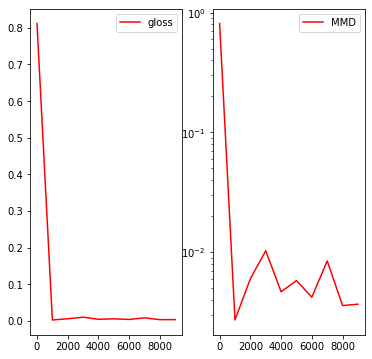

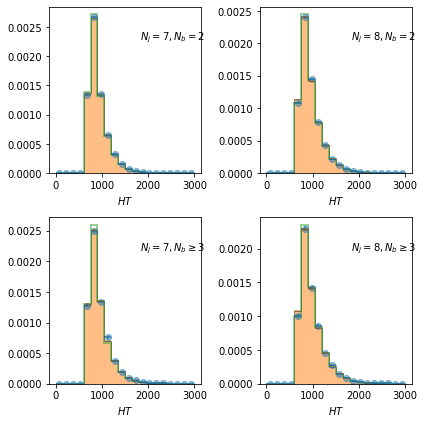

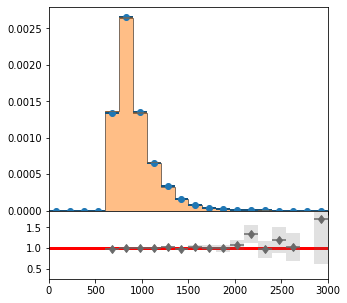

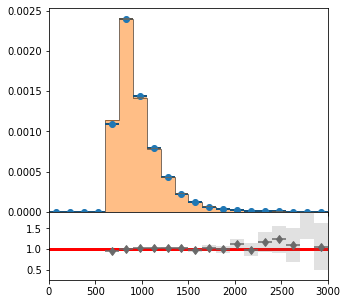

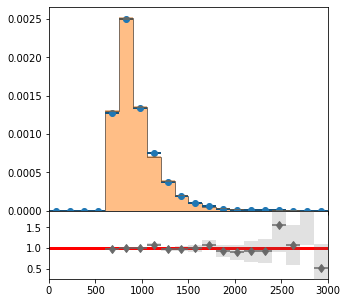

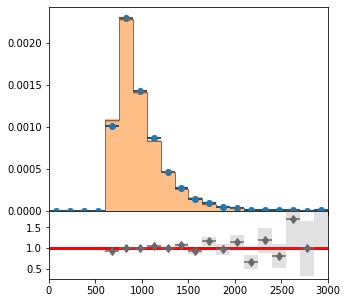

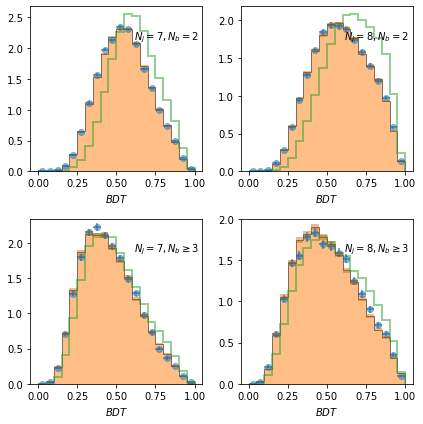

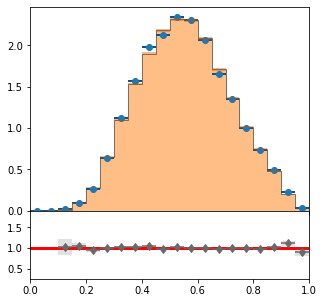

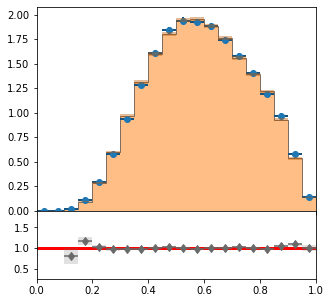

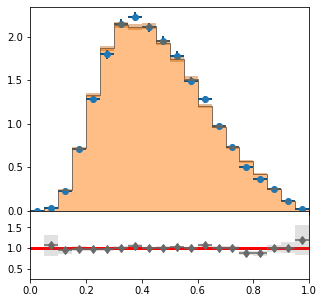

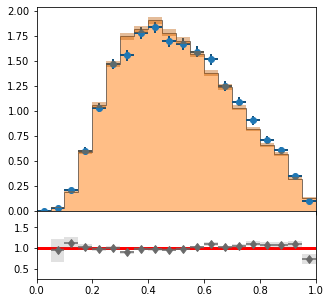

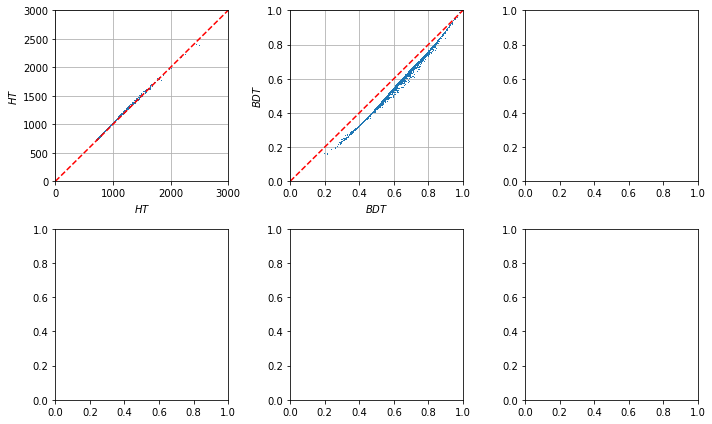

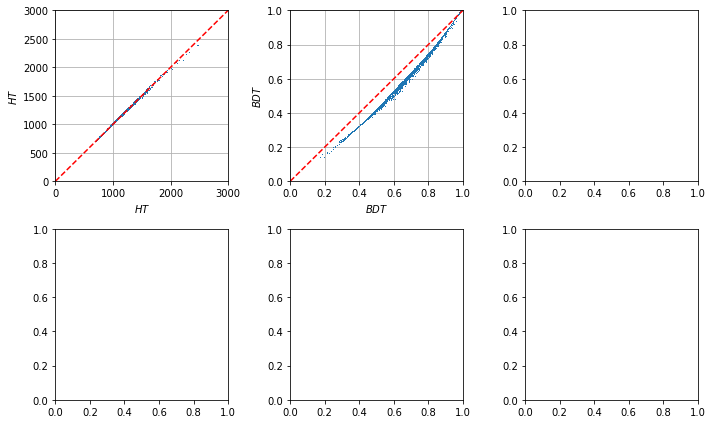

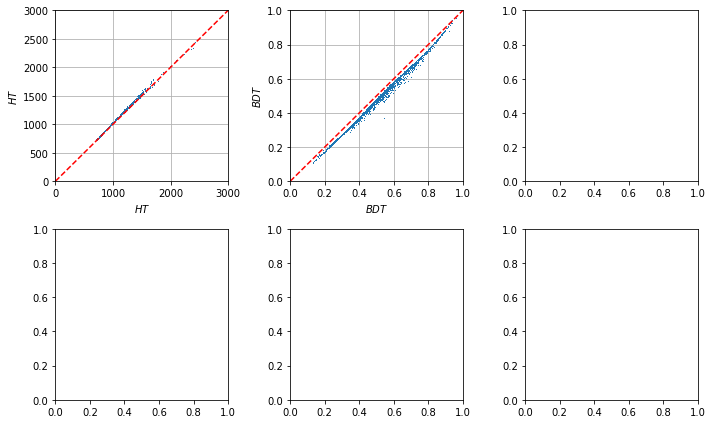

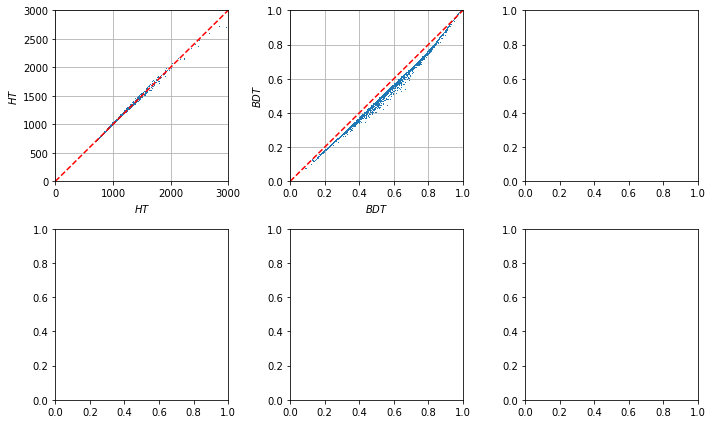

In [13]:
NDense= 64
minibatch= 1024
lr= 0.0001
gap= 5000.0
beta1 = 0.9
beta2 = 0.999
Nafdim= 30
Depth= 3
seed=101

sdir = datadir + '/ABCDnn'
train_and_validate(steps=10000, ndense=NDense, minibatch=minibatch, lr=lr, gap=gap, beta1=beta1, beta2=beta2, \
    savedir=sdir, nafdim=Nafdim, depth=Depth, seed=seed, retrain=True, train=True, mc_weight=None, title_step='10k')



[0, 0, 3, 2]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_17 (Sl (None, 2)            0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor_12 (TFOpLa (None, 2)            0           tf.__operators__.getitem_17[0][0]
__________________________________________________________________________________________________
tf.compat.v1.gather_12 (TFOpLam (None, 2)            0           tf.convert_to_tensor_12[0][0]    
_______________________________________________________________________________

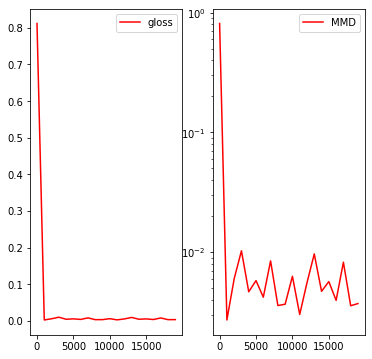

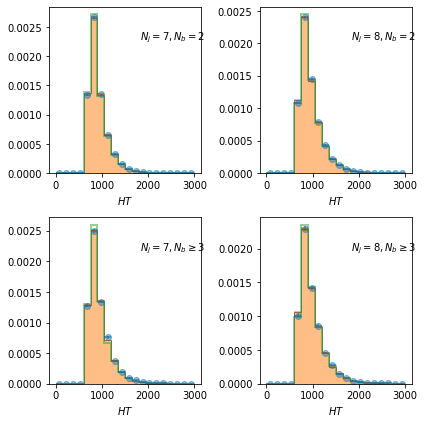

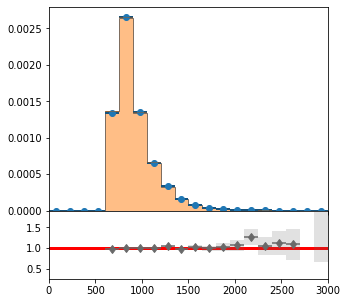

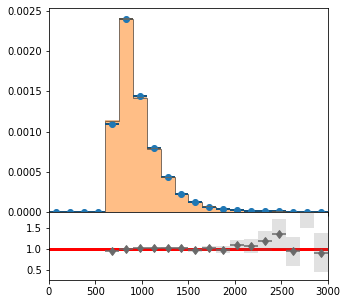

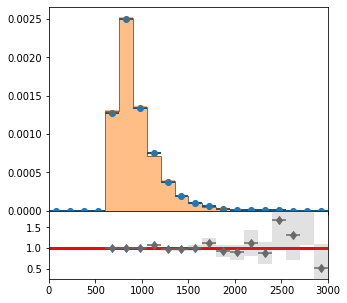

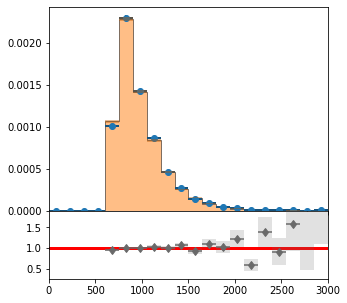

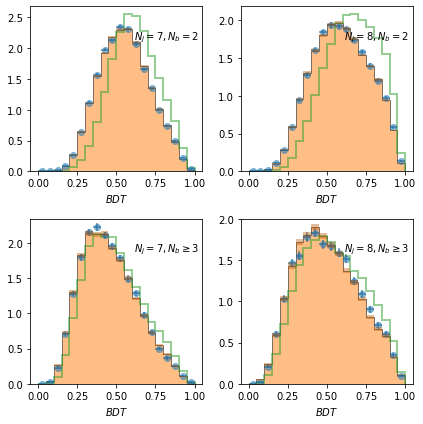

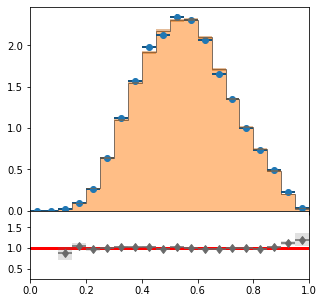

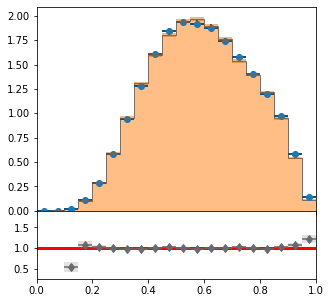

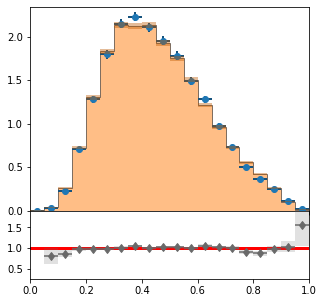

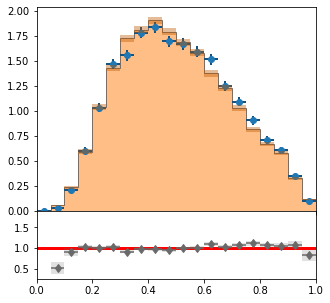

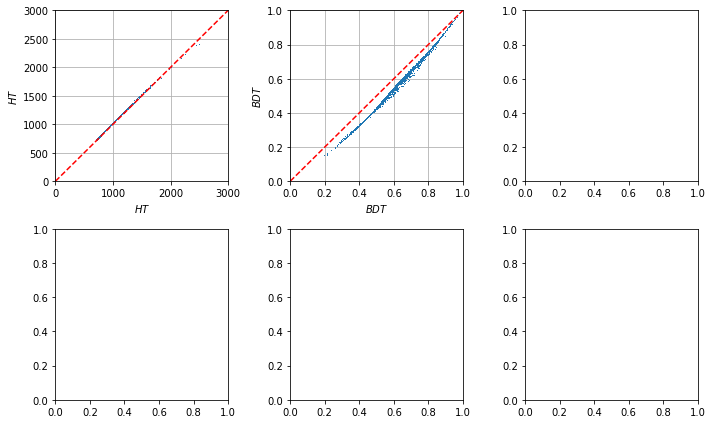

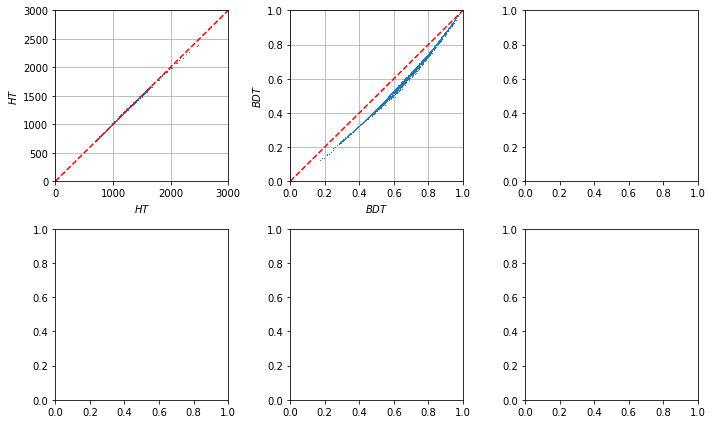

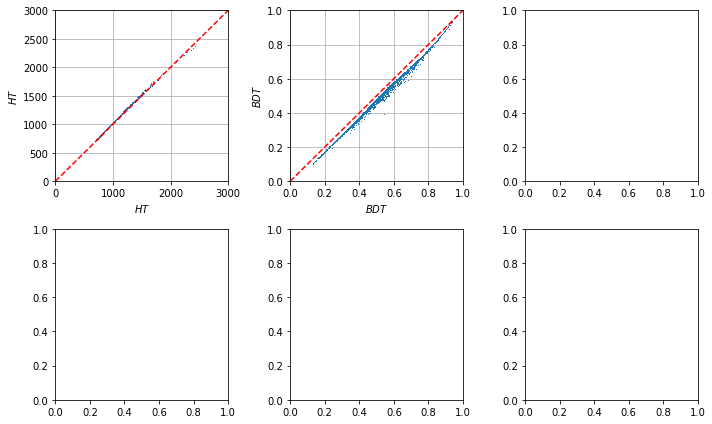

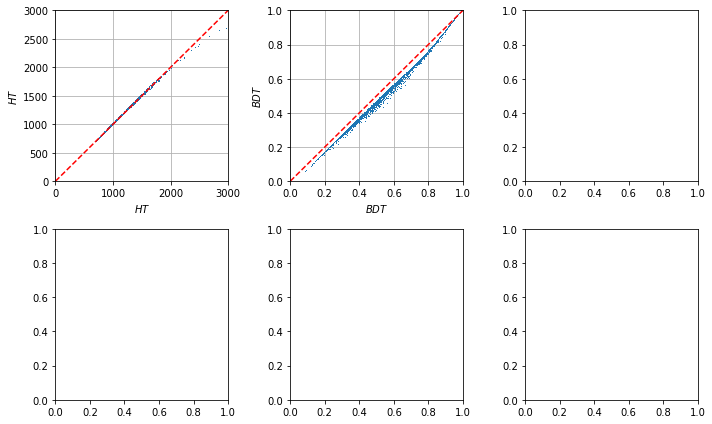

In [14]:
train_and_validate(steps=10000, ndense=NDense, minibatch=minibatch, lr=lr, gap=gap, beta1=beta1, beta2=beta2, \
    savedir=sdir, nafdim=Nafdim, depth=Depth, seed=seed, retrain=False, train=True, mc_weight=None, title_step='20k')